# Frequency Regulation Study

In [1]:
import ams

In [2]:
%matplotlib inline

In [3]:
ams.config_logger(stream_level=20)

## Real-time economic dispatch

In [4]:
sp = ams.load('./ieee39_econ.xlsx',
              setup=True,
              no_output=True,
              default_config=True)

Working directory: "/Users/jinningwang/work/demo/demo/freq_regulation"
Parsing input file "./ieee39_econ.xlsx"...
Input file parsed in 0.0332 seconds.
System set up in 0.0017 seconds.


In [5]:
sp.RTED.run(solver='CLARABEL')

Building system matrices
Parsing OModel for <RTED>
Evaluating OModel for <RTED>
Finalizing OModel for <RTED>
<RTED> initialized in 0.0135 seconds.
<RTED> solved as optimal in 0.0132 seconds, converged in 10 iterations with CLARABEL.


True

In [6]:
sp.RTED.dc2ac()

Parsing OModel for <ACOPF>
Evaluating OModel for <ACOPF>
Finalizing OModel for <ACOPF>
<ACOPF> initialized in 0.0038 seconds.
<ACOPF> solved in 0.3166 seconds, converged in 23 iterations with PYPOWER-PIPS.
Parsing OModel for <RTED>
<RTED> converted to AC.


True

## Generator Trip Transient Simulation

In [7]:
sa = sp.to_andes(setup=True,
                 addfile='./ieee39_dyn.xlsx',
                 no_output=True,
                 default_config=True,
                 verify=False)

> Reloaded generated Python code of module "pycode".
Parsing additional file "./ieee39_dyn.xlsx"...
Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Shunt>, <Line>, <Area>
Addfile parsed in 0.0712 seconds.
System converted to ANDES in 0.1256 seconds.
AMS system 0x157029b40 is linked to the ANDES system 0x157dda170.
System internal structure set up in 0.0199 seconds.


In [8]:
sp.dyn.send(routine='RTED')

Send <RTED> results to ANDES <0x157dda170>...
*Send <vBus> to StaticGen.v0
Send <vBus> to Bus.v0
Send <ug> to StaticGen.u
Send <pg> to StaticGen.p0


True

In [9]:
sa.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0042 seconds.
0: |F(x)| = 3.30837325
1: |F(x)| = 0.143705758
2: |F(x)| = 0.0004713260361
3: |F(x)| = 6.174227463e-09
Converged in 4 iterations in 0.0030 seconds.


True

In [10]:
_ = sa.TDS.init()

GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for dynamics completed in 0.0459 seconds.
Initialization was successful.


In [11]:
syg_tripped = sa.Toggler.dev.v[0]
p_gap = sa.GENROU.Pe.v[sa.GENROU.idx2uid(syg_tripped)]

In [12]:
sa.TDS.config.tf = 50
sa.TDS.config.criteria = 0
sa.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-50 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggler_1>: GENROU.GENROU_3 status changed to 0 at t=1.0 sec.


Simulation to t=50.00 sec completed in 1.6110 seconds.


True

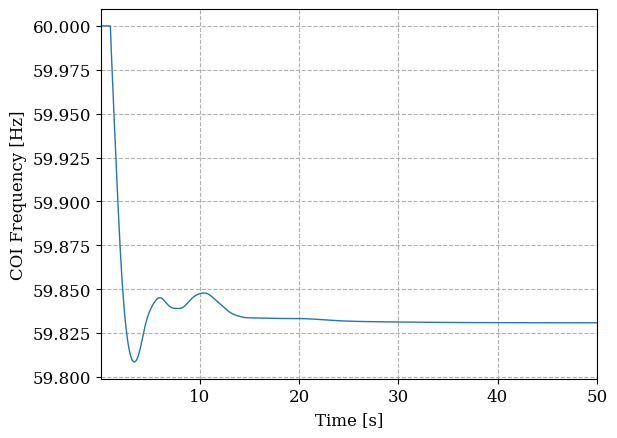

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time [s]', ylabel='COI Frequency [Hz]'>)

In [13]:
sa.TDS.plt.plot(sa.COI.omega,
                ytimes=sa.config.freq,
                latex=False,
                grid=True,
                legend=False,
                ylabel='COI Frequency [Hz]')

# Post Contingency Calculation

In [14]:
print(f'Generator being tripped: {syg_tripped}')
print(f'Tripped power: {sa.config.mva * p_gap:.2f} MW')

bias = sa.ACEc.bias.v[0]
f_dev =  1 - sa.COI.omega.v
p_est = bias * 10 * sa.config.freq * f_dev
print(f'Estimated power gap: {p_est[0]:.2f} MW')

Generator being tripped: GENROU_3
Tripped power: 607.93 MW
Estimated power gap: 592.02 MW
